<a href="https://colab.research.google.com/github/GeorgeSherif/ChatEGP/blob/main/Translate_Ar_En.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing & Importing the Necessary Libraries and Mounting the drive**

In [1]:
!pip3 install transformers sentencepiece nltk protobuf torch pygal simpletransformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 19

In [1]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import os
import warnings
import csv
from textblob import TextBlob
import re
from nltk.stem.isri import ISRIStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import pygal as py
import matplotlib
plt.rcParams["figure.figsize"] = (8,5)
matplotlib.rc('xtick', labelsize=7) 
matplotlib.rc('ytick', labelsize=7) 

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Approach 1: Evaluate the English Model (BERT)**


*   English Train Data
*   Arabic Test Data
*   Train with the English Dataset
*   Translate the Arabic Dataset
*   Evaluate Model





### Load the English Dataset

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/NLP/English Dataset.csv' ,engine="python", encoding = "ISO-8859-1")
df

,Sentiment,Sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [4]:
df.describe()

,Sentiment,Sentence
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


<Axes: xlabel='count', ylabel='Sentiment'>

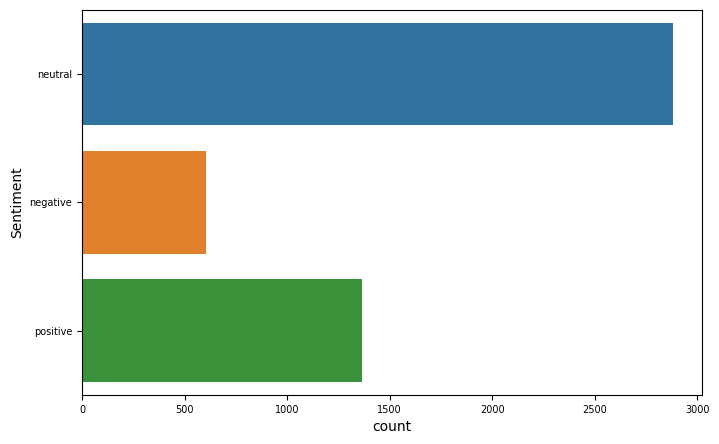

In [5]:
sns.countplot(y="Sentiment",data=df)

In [6]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df

,Sentiment,Sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [7]:
df.describe()

,Sentiment,Sentence
count,4838,4838
unique,3,4838
top,neutral,"According to Gran , the company has no plans t..."
freq,2872,1


### Determinig the sentiment using TextBlob Polarity

In [8]:
from textblob import TextBlob
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Review Text'] = preprocess(df['Sentence'])

df['polarity'] = df['Sentence'].map(lambda text: TextBlob(text).sentiment.polarity)
df['sentence_len'] = df['Sentence'].astype(str).apply(len)
df['word_count'] = df['Sentence'].apply(lambda x: len(str(x).split()))

In [9]:
df

,Sentiment,Sentence,Review Text,polarity,sentence_len,word_count
0,neutral,"According to Gran , the company has no plans t...","According to Gran , the company has no plans t...",0.000000,127,25
1,neutral,Technopolis plans to develop in stages an area...,Technopolis plans to develop in stages an area...,0.083333,190,31
2,negative,The international electronic industry company ...,The international electronic industry company ...,0.000000,228,36
3,positive,With the new production plant the company woul...,With the new production plant the company woul...,-0.064802,206,33
4,positive,According to the company 's updated strategy f...,According to the company 's updated strategy f...,0.000000,203,41
...,...,...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,LONDON MarketWatch -- Share prices ended lower...,-0.500000,144,26
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0.000000,148,30
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,Operating profit fell to EUR 35.4 mn from EUR ...,0.000000,108,23
4844,negative,Net sales of the Paper segment decreased to EU...,Net sales of the Paper segment decreased to EU...,0.040000,226,44


### Sentiment Analysis using BERT

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [11]:
train

,Sentiment,Sentence,Review Text,polarity,sentence_len,word_count
4067,negative,Operating profit was EUR 1.6 mn in 2005 compar...,Operating profit was EUR 1.6 mn in 2005 compar...,0.000000,72,16
433,positive,"In September 2010 , the Finnish group agreed t...","In September 2010 , the Finnish group agreed t...",0.600000,141,29
3174,neutral,"The businesses to be divested offer dairy , ed...","The businesses to be divested offer dairy , ed...",0.000000,131,21
290,positive,The company is in the process of building a ne...,The company is in the process of building a ne...,0.136364,112,23
2587,neutral,The Board of Directors was authorized to decid...,The Board of Directors was authorized to decid...,-0.125000,83,16
...,...,...,...,...,...,...
4434,negative,Vaisala 's net profit for the third quarter of...,Vaisala 's net profit for the third quarter of...,0.000000,151,36
467,positive,`` Residentialconstruction in particular has p...,`` Residentialconstruction in particular has p...,0.083333,75,11
3099,neutral,R&D Loan ) .,R&D Loan ) .,0.000000,12,4
3780,neutral,The closing of such transaction took place tod...,The closing of such transaction took place tod...,0.000000,50,9


In [12]:
from simpletransformers.classification import ClassificationModel


# Create a TransformerModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=3, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [15]:
# 0,1,2 : positive,negative
def making_label(st):
    if(st=='positive'):
        return 0
    elif(st=='neutral'):
        return 2
    else:
        return 1
    
train['label'] = train['Sentiment'].apply(making_label)
test['label'] = test['Sentiment'].apply(making_label)
print(train.shape)

(3870, 7)


In [16]:
train_df = pd.DataFrame({
    'text': train['Sentence'][:1500].replace(r'\n', ' ', regex=True),
    'label': train['label'][:1500]
})

eval_df = pd.DataFrame({
    'text': test['Sentence'][-400:].replace(r'\n', ' ', regex=True),
    'label': test['label'][-400:]
})

In [17]:
model.train_model(train_df)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/188 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

### Uploading the MarianMTModel Translator

In [7]:
from transformers import MarianTokenizer, MarianMTModel
mname = "marefa-nlp/marefa-mt-en-ar"
tokenizer = MarianTokenizer.from_pretrained(mname)
model = MarianMTModel.from_pretrained(mname)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


### Translating the dataset

In [8]:
# English Text
input = "With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability."

translated_tokens = model.generate(**tokenizer.prepare_seq2seq_batch([input], return_tensors="pt"))
translated_text = [tokenizer.decode(t, skip_special_tokens=True) for t in translated_tokens]

# translated Arabic Text
print(translated_text)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['مع مصنع الإنتاج الجديد ستزيد الشركة من قدرتها على تلبية الزيادة المتوقعة في الطلب وستحسن استخدام المواد الخام وبالتالي تزيد من الربحية الإنتاجية.']


In [9]:
# Directory containing the text files to merge
dir_path = 'gdrive/My Drive/Finance/'

# List of all the text files in the directory
files = os.listdir(dir_path)
print(files)

# Open the CSV file for writing
with open('merged_file.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row to the CSV file
    writer.writerow(['filename', 'content'])

    # Iterate through all the text files in the directory
    for file in files:
        if file.endswith('.txt'):
            # Open the text file for reading
            with open(os.path.join(dir_path, file), 'r') as f:
                content = f.read()
                
            # Write the filename and content to the CSV file
            writer.writerow([file, content])

# Close the CSV file
csvfile.close()

['6300.txt', '4706.txt', '4800.txt', '4726.txt', '4840.txt', '5959.txt', '4930.txt', '4727.txt', '4337.txt', '4990.txt', '4322.txt', '5151.txt', '5778.txt', '6378.txt', '6016.txt', '6121.txt', '6136.txt', '5937.txt', '6043.txt', '6472.txt', '4722.txt', '4427.txt', '4775.txt', '5317.txt', '5606.txt', '6308.txt', '6245.txt', '4422.txt', '5726.txt', '4442.txt', '6172.txt', '5442.txt', '6167.txt', '5661.txt', '6165.txt', '4957.txt', '5329.txt', '5313.txt', '4913.txt', '5597.txt', '4925.txt', '5117.txt', '5931.txt', '6161.txt', '5242.txt', '5520.txt', '6116.txt', '5255.txt', '5892.txt', '4943.txt', '5085.txt', '4314.txt', '5207.txt', '5991.txt', '5722.txt', '4816.txt', '5530.txt', '5421.txt', '5919.txt', '5428.txt', '5873.txt', '6478.txt', '5232.txt', '4912.txt', '4458.txt', '6211.txt', '4448.txt', '5366.txt', '6272.txt', '6215.txt', '4290.txt', '5829.txt', '4618.txt', '5155.txt', '5518.txt', '6450.txt', '6254.txt', '4661.txt', '4980.txt', '6228.txt', '5528.txt', '4363.txt', '6083.txt', '61

In [10]:
df = pd.read_csv("merged_file.csv")
print(df.describe)

<bound method NDFrame.describe of       filename                                            content
0     6300.txt  بلغت تسييلات الأجانب في سوق دبي المالي أمس 59 ...
1     4706.txt  تواصلت مسيرة الصعود في البورصات الإقليمية وسط ...
2     4800.txt  انخفض المؤشر العام لسوق أبوظبي للأوراق المالية...
3     4726.txt  أبوظبي:«الخليج»أغلق المؤشر العام لسوق أبوظبي ل...
4     4840.txt  أبوظبي علي أسعد: رغم تراجع أسعار النفط أمس إلا...
...        ...                                                ...
6495  0688.txt  أعلنت شركة “إعمار العقارية” في إفصاح لسوق دبي ...
6496  1055.txt  قلصت أسواق الأسهم المحلية خسائرها خلال جلسة ال...
6497  0393.txt  قال خبراء في أسواق الأسهم المحلية إن التحدي ال...
6498  0270.txt  واصلت مؤشرات أسواق المال في الدولة صعودها على ...
6499  0583.txt  بلغت قيمة مشتريات الأجانب، غير العرب، من الأسه...

[6500 rows x 2 columns]>
